# Cubicasa Parser

This is the prototype for parsing the cubicasa svg files into images.

## References
https://github.com/CubiCasa/CubiCasa5k

In [32]:
import math
import numpy as np
from xml.dom import minidom
from skimage.draw import polygon
from svgpathtools import parse_path
from logging import warning
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [8]:
def get_labels(path, height, width):
    svg = minidom.parse(path)
    walls = np.empty((height, width), dtype=np.uint8)
    walls.fill(len(rooms))
    icons = np.zeros((height, width), dtype=np.uint8)
    for e in svg.getElementsByTagName('g'):
        if e.getAttribute("id") == "Wall":
            rr, cc = get_polygon(e)
            walls[rr, cc] = 0

        if e.getAttribute("id") == "Window":
            rr, cc = get_polygon(e)
            icons[rr, cc] = 1

        if e.getAttribute("id") == "Door":
            # How to reperesent empty door space
            rr, cc = get_polygon(e)
            icons[rr, cc] = 2

        if "FixedFurniture " in e.getAttribute("class"):
            num = get_icon_number(e)
            rr, cc = get_icon(e)
            icons[rr, cc] = num

        if "Space " in e.getAttribute("class"):
            num = get_room_number(e)
            rr, cc = get_polygon(e)
            walls[rr, cc] = num

    return walls, icons


def get_room_number(e, rooms):
    name_list = e.getAttribute("class").split(" ")
    room_type = name_list[1]
    try:
        return rooms[room_type]
    except KeyError:
        warning("Room type " + e.getAttribute("class") + " not defined.")
        return rooms['Undefined']


def get_icon_number(e, icons):
    name_list = e.getAttribute("class").split(" ")
    icon_type = name_list[1]

    try:
        return icons[icon_type]
    except KeyError:
        warning("Icon type " + e.getAttribute("class") + " not defined.")
        return icons['Misc']


def get_icon(ee):
    parent_transform = None
    if ee.parentNode.getAttribute("class") == "FixedFurnitureSet":
        parent_transform = ee.parentNode.getAttribute("transform")
        strings = parent_transform.split(',')
        a_p = float(strings[0][7:])
        b_p = float(strings[1])
        c_p = float(strings[2])
        d_p = float(strings[3])
        e_p = float(strings[-2])
        f_p = float(strings[-1][:-1])
        M_p = np.array([[a_p, c_p, e_p],
                        [b_p, d_p, f_p],
                        [0, 0, 1]])

    transform = ee.getAttribute("transform")
    strings = transform.split(',')
    a = float(strings[0][7:])
    b = float(strings[1])
    c = float(strings[2])
    d = float(strings[3])
    e = float(strings[-2])
    f = float(strings[-1][:-1])

    M = np.array([[a, c, e],
                  [b, d, f],
                  [0, 0, 1]])

    X = np.array([])
    Y = np.array([])

    try:
        toilet = next(p for p in ee.childNodes if p.nodeName ==
                      'g' and p.getAttribute("class") == "BoundaryPolygon")

        for p in toilet.childNodes:
            if p.nodeName == "polygon":
                X, Y = get_icon_polygon(p)
                break
        else:
            x_all, y_all = get_corners(toilet)
            points = np.column_stack((x_all, y_all))

            X, Y = get_max_corners(points)
            # if p.nodeName == "path":
                # X, Y = get_icon_path(p)

    except StopIteration:
        X, Y = make_boudary_polygon(ee)

    if len(X) < 4:
        return None, None, X, Y

    if parent_transform is not None:
        for i in range(len(X)):
            v = np.matrix([[X[i]], [Y[i]], [1]])
            vv = np.matmul(M, v)
            new_x, new_y, _ = np.round(np.matmul(M_p, vv))
            X[i] = new_x
            Y[i] = new_y
    else:
        for i in range(len(X)):
            v = np.matrix([[X[i]], [Y[i]], [1]])
            vv = np.matmul(M, v)
            new_x, new_y, _ = np.round(vv)
            X[i] = new_x
            Y[i] = new_y

    rr, cc = polygon(Y, X)

    return rr, cc, X, Y

def get_corners(g):
    x_all, y_all = [], []
    for pol in g.childNodes:
        if pol.nodeName == 'polygon':
            x, y = get_icon_polygon(pol)
            x_all = np.append(x_all, x)
            y_all = np.append(y_all, y)
        elif pol.nodeName == 'path':
            x, y = get_icon_path(pol)
            x_all = np.append(x_all, x)
            y_all = np.append(y_all, y)
        elif pol.nodeName == 'rect':
            x = pol.getAttribute('x')
            if x == '':
                x = 1.0
            else:
                x = float(x)
            y = pol.getAttribute('y')
            if y == '':
                y = 1.0
            else:
                y = float(y)
            x_all = np.append(x_all, x)
            y_all = np.append(y_all, y)
            w = float(pol.getAttribute('width'))
            h = float(pol.getAttribute('height'))
            x_all = np.append(x_all, x+w)
            y_all = np.append(y_all, y+h)

    return x_all, y_all


def get_max_corners(points):
    if len(points) == 0:
        return [], []

    minx, miny = float("inf"), float("inf")
    maxx, maxy = float("-inf"), float("-inf")
    for x, y in points:
        # Set min coords
        if x < minx:
            minx = x
        if y < miny:
            miny = y
        # Set max coords
        if x > maxx:
            maxx = x
        elif y > maxy:
            maxy = y

    X = np.array([minx, maxx, maxx, minx])
    Y = np.array([miny, miny, maxy, maxy])

    return X, Y


def make_boudary_polygon(pol):
    g_gen = (c for c in pol.childNodes if c.nodeName == 'g')

    x_all, y_all = [], []
    for g in g_gen:
        x, y = get_corners(g)
        x_all = np.append(x_all, x)
        y_all = np.append(y_all, y)

    points = np.column_stack((x_all, y_all))
    X, Y = get_max_corners(points)

    return X, Y


def get_icon_path(pol):
    path = pol.getAttribute("d")
    try:
        path_alt = parse_path(path)
        minx, maxx, miny, maxy = path_alt.bbox()
    except ValueError as e:
        print("Error handled")
        print(e)
        return np.array([]), np.array([])

    X = np.array([minx, maxx, maxx, minx])
    Y = np.array([miny, miny, maxy, maxy])

    if np.unique(X).size == 1 or np.unique(Y).size == 1:
        return np.array([]), np.array([])

    return X, Y


def get_icon_polygon(pol):
    points = pol.getAttribute("points").split(' ')

    return get_XY(points)


def get_XY(points):
    if points[-1] == "":
        points = points[:-1]

    if points[0] == "":
        points = points[1:]

    X, Y = np.array([]), np.array([])
    i = 0
    for a in points:
        if ',' in a:
            if len(a) == 2:
                x, y = a.split(',')
            else:
                num_list = a.split(',')
                x, y = num_list[0], num_list[1]
            X = np.append(X, np.round(float(x)))
            Y = np.append(Y, np.round(float(y)))
        else:
            # if no comma every other is x and every other is y
            if i % 2:
                Y = np.append(Y, float(a))
            else:
                X = np.append(X, float(a))

        i += 1

    return X, Y


def get_points(e):
    pol = next(p for p in e.childNodes if p.nodeName == "polygon")
    points = pol.getAttribute("points").split(' ')
    points = points[:-1]

    X, Y = np.array([]), np.array([])
    for a in points:
        x, y = a.split(',')
        X = np.append(X, np.round(float(x)))
        Y = np.append(Y, np.round(float(y)))

    return X, Y


def get_direction(X, Y):
    max_diff_X = abs(max(X) - min(X))
    max_diff_Y = abs(max(Y) - min(Y))

    if max_diff_X > max_diff_Y:
        return "H"  # horizontal
    else:
        return "V"  # vertical


def get_polygon(e):
    pol = next(p for p in e.childNodes if p.nodeName == "polygon")
    points = pol.getAttribute("points").split(' ')
    points = points[:-1]

    X, Y = np.array([]), np.array([])
    for a in points:
        y, x = a.split(',')
        X = np.append(X, np.round(float(x)))
        Y = np.append(Y, np.round(float(y)))

    rr, cc = polygon(X, Y)

    return rr, cc


def calc_distance(point_1, point_2):
    return math.sqrt(math.pow(point_1[0] - point_2[0], 2) +
                     math.pow(point_1[1] - point_2[1], 2))


def calc_center(points):
    return list(np.mean(np.array(points), axis=0))


def get_gaussian2D(ndim, sigma=0.25):
    over_sigmau = 1.0 / (sigma * ndim)
    over_sigmav = 1.0 / (sigma * ndim)
    dst_data = np.zeros((ndim, ndim))

    mean_u = 0.5 * ndim + 0.5
    mean_v = 0.5 * ndim + 0.5

    for v in range(ndim):
        for u in range(ndim):
            du = (u + 1 - mean_u) * over_sigmau
            dv = (v + 1 - mean_v) * over_sigmav
            value = np.exp(-0.5 * (du * du + dv * dv))
            dst_data[v][u] = value

    return dst_data


def draw_junction(index, point, width, height, axes):
    lineLength = 15
    lineWidth = 7
    x, y = point[0]
    axes.text(x, y, str(index), fontsize=15, color='k')
    ###########################
    # o
    # | #6488ea soft blue
    # | drawcode = [1,1]
    #
    ###########################
    if point[2][1] == 1 and point[2][2] == 1:
        axes.plot([x, x], [y, min(y + lineLength, height - 1)],
                  linewidth=lineWidth, color='#6488ea')
    ###########################
    #
    #  ---o #6241c7 bluey purple
    #     drawcode = [1,2]
    #
    ###########################
    elif point[2][1] == 1 and point[2][2] == 2:
        axes.plot([x, max(x - lineLength, 0)], [y, y],
                  linewidth=lineWidth, color='#6241c7')
    ###########################
    #    |
    #    | drawcode = [1,3]
    #    o #056eee cerulean blue
    #
    ###########################
    elif point[2][1] == 1 and point[2][2] == 3:
        axes.plot([x, x], [y, max(y - lineLength, 0)],
                  linewidth=lineWidth, color='#056eee')
    ###########################
    #
    #  drawcode = [1,4]
    #
    #  o--- #004577 prussian blue
    #
    ###########################
    elif point[2][1] == 1 and point[2][2] == 4:
        axes.plot([x, min(x + lineLength, width - 1)], [y, y],
                  linewidth=lineWidth, color='#004577')
    ###########################
    #
    # |--- drawcode = [2,3]
    # |
    #
    ###########################
    elif point[2][1] == 2 and point[2][2] == 3:
        axes.plot([x, min(x + lineLength, width - 1)], [y, y],
                  linewidth=lineWidth, color='#04d8b2')
        axes.plot([x, x], [y, min(y + lineLength, height - 1)],
                  linewidth=lineWidth, color='#04d8b2')
    ###########################
    #
    #  ---|
    #     | drawcode = [2,4]
    #
    ###########################
    elif point[2][1] == 2 and point[2][2] == 4:
        axes.plot([x, max(x - lineLength, 0)], [y, y],
                  linewidth=lineWidth, color='#cdfd02')
        axes.plot([x, x], [y, min(y + lineLength, height - 1)],
                  linewidth=lineWidth, color='#cdfd02')
    ###########################
    #    |
    # ---| drawcode = [2,1]
    #
    #
    ###########################
    elif point[2][1] == 2 and point[2][2] == 1:
        axes.plot([x, max(x - lineLength, 0)], [y, y],
                  linewidth=lineWidth, color='#ff81c0')
        axes.plot([x, x], [y, max(y - lineLength, 0)],
                  linewidth=lineWidth, color='#ff81c0')
    ###########################
    #
    #  |
    #  | drawcode = [2,2]
    #  --
    #
    ###########################
    elif point[2][1] == 2 and point[2][2] == 2:
        axes.plot([x, min(x + lineLength, width - 1)], [y, y],
                  linewidth=lineWidth, color='#f97306')
        axes.plot([x, x], [y, max(y - lineLength, 0)],
                  linewidth=lineWidth, color='#f97306')
    ###########################
    #
    # |
    # |--- drawcode = [3,4]
    # |
    #
    ###########################
    elif point[2][1] == 3 and point[2][2] == 4:
        axes.plot([x, min(x + lineLength, width - 1)],
                  [y, y], linewidth=lineWidth, color='b')
        axes.plot([x, x], [y, max(y - lineLength, 0)],
                  linewidth=lineWidth, color='b')
        axes.plot([x, x], [y, min(y + lineLength, height - 1)],
                  linewidth=lineWidth, color='b')
    ###########################
    #
    # ---
    #  |  drawcode = [3,1]
    #  |
    #
    ###########################
    elif point[2][1] == 3 and point[2][2] == 1:
        axes.plot([x, min(x + lineLength, width - 1)],
                  [y, y], linewidth=lineWidth, color='y')
        axes.plot([x, max(x - lineLength, 0)], [y, y],
                  linewidth=lineWidth, color='y')
        axes.plot([x, x], [y, min(y + lineLength, height - 1)],
                  linewidth=lineWidth, color='y')
    ###########################
    #
    #    |
    # ---| drawcode = [3,2]
    #    |
    #
    ###########################
    elif point[2][1] == 3 and point[2][2] == 2:
        axes.plot([x, max(x - lineLength, 0)], [y, y],
                  linewidth=lineWidth, color='r')
        axes.plot([x, x], [y, max(y - lineLength, 0)],
                  linewidth=lineWidth, color='r')
        axes.plot([x, x], [y, min(y + lineLength, height - 1)],
                  linewidth=lineWidth, color='r')
    ###########################
    #
    #  |
    #  | drawcode = [3,3]
    # ---
    #
    ###########################
    elif point[2][1] == 3 and point[2][2] == 3:
        axes.plot([x, min(x + lineLength, width - 1)],
                  [y, y], linewidth=lineWidth, color='m')
        axes.plot([x, max(x - lineLength, 0)], [y, y],
                  linewidth=lineWidth, color='m')
        axes.plot([x, x], [y, max(y - lineLength, 0)],
                  linewidth=lineWidth, color='m')
    ###########################
    #
    #  |
    # --- drawcode = [4,1]
    #  |
    #
    ###########################
    elif point[2][1] == 4 and point[2][2] == 1:
        axes.plot([x, min(x + lineLength, width - 1)],
                  [y, y], linewidth=lineWidth, color='k')
        axes.plot([x, max(x - lineLength, 0)], [y, y],
                  linewidth=lineWidth, color='k')
        axes.plot([x, x], [y, max(y - lineLength, 0)],
                  linewidth=lineWidth, color='k')
        axes.plot([x, x], [y, min(y + lineLength, height - 1)],
                  linewidth=lineWidth, color='k')

In [9]:
class Wall:
    def __init__(self, id, end_points, direction, width, name):
        self.id = id
        self.name = name
        self.end_points = end_points
        self.direction = direction
        self.max_width = width
        self.min_width = width

    def change_end_points(self):
        if self.direction == 'V':
            self.end_points[0][0] = np.mean(np.array(self.min_coord))
            self.end_points[1][0] = self.end_points[0][0]
        elif self.direction == 'H':
            self.end_points[0][1] = np.mean(np.array(self.min_coord))
            self.end_points[1][1] = self.end_points[0][1]

    def get_length(self, end_points):
        return calc_distance(end_points[0], end_points[1])

In [10]:
class LineWall(Wall):
    def __init__(self, id, end_points, direction, width, name):
        Wall.__init__(self, id, end_points, direction, width, name)

In [12]:
class PolygonWall(Wall):
    def __init__(self, e, id, shape=None):
        self.id = id
        self.name = e.getAttribute('id')
        self.X, self.Y = self.get_points(e)
        if abs(max(self.X)-min(self.X)) < 4 or abs(max(self.Y)-min(self.Y)) < 4:
            # wall is too small and we ignore it.
            raise ValueError("small wall")
        if shape:
            self.X = np.clip(self.X, 0, shape[1])
            self.Y = np.clip(self.Y, 0, shape[0])
        # self.X, self.Y = self.sort_X_Y(self.X, self.Y)
        self.rr, self.cc = polygon(self.Y, self.X)
        direction = self.get_direction(self.X, self.Y)
        end_points = self.get_end_points(self.X, self.Y, direction)
        self.min_width = self.get_width(self.X, self.Y, direction)
        self.max_width = self.min_width

        Wall.__init__(self, id, end_points, direction, self.max_width, self.name)
        self.length = self.get_length(self.end_points)
        self.center = self.get_center(self.X, self.Y)
        self.min_coord, self.max_coord = self.get_width_coods(self.X, self.Y)

    def get_points(self, e):
        pol = next(p for p in e.childNodes if p.nodeName == "polygon")
        points = pol.getAttribute("points").split(' ')
        points = points[:-1]

        X, Y = np.array([]), np.array([])
        for a in points:
            x, y = a.split(',')
            X = np.append(X, np.round(float(x)))
            Y = np.append(Y, np.round(float(y)))

        return X, Y

    def get_direction(self, X, Y):
        max_diff_X = abs(max(X) - min(X))
        max_diff_Y = abs(max(Y) - min(Y))

        if max_diff_X > max_diff_Y:
            return "H"  # horizontal
        else:
            return "V"  # vertical

    def get_center(self, X, Y):
        return np.mean(X), np.mean(Y)

    def get_width(self, X, Y, direction):
        _, _, p1, p2 = self._get_min_points(X, Y)

        if direction == 'H':
            return (abs(p1[0][1] - p1[1][1]) + abs(p2[0][1] - p2[1][1])) / 2
        elif 'V':
            return (abs(p1[0][0] - p1[1][0]) + abs(p2[0][0] - p2[1][0])) / 2

    def _width(self, values):
        temp = values.tolist() if type(values) is not list else values

        mean_1 = min(temp)
        mean_2 = max(temp)

        return abs(mean_1 - mean_2)

    def merge_possible(self, merged):
        max_dist = max([self.max_width, merged.max_width])

        if self.id == merged.id:
            return False

        # walls have to be in the same direction
        if self.direction != merged.direction:
            return False

        # walls have too big width difference
        if abs(self.max_width - merged.max_width) > merged.max_width:
            return False

        # If endpoints are near
        # self up and left endpoint to merged down and right end point
        dist1 = calc_distance(self.end_points[0], merged.end_points[1])
        # self down and right endpoint to merged up and left end point
        dist2 = calc_distance(self.end_points[1], merged.end_points[0])

        if dist1 <= max_dist * 1.5 or dist2 <= max_dist * 1.5:
            return True
        else:
            return False

    def _get_overlap(self, a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))
        
    def merge_walls(self, merged):
        max_dist = max([self.max_width, merged.max_width])

        if self.id == merged.id:
            return None

        # walls have to be in the same direction
        if self.direction != merged.direction:
            return None


        # If endpoints are near
        # self up and left endpoint to merged down and right end point
        dist1 = calc_distance(self.end_points[0], merged.end_points[1])
        # self down and right endpoint to merged up and left end point
        dist2 = calc_distance(self.end_points[1], merged.end_points[0])

        if dist1 <= max_dist * 1.5:
            if self._get_overlap(self.min_coord, merged.min_coord) <= 0:
                return None
            # merged is on top or on left
            return self.do_merge(merged, 0)
        elif dist2 <= max_dist * 1.5:
            if self._get_overlap(self.min_coord, merged.min_coord) <= 0:
                return None
            # merged is on down or on right
            return self.do_merge(merged, 1)
        else:
            return None

    def _get_min_points(self, X, Y):
        assert len(X) == 4 and len(Y) == 4
        length = len(X)
        min_dist1 = np.inf
        min_dist2 = np.inf
        point1 = None
        point2 = None
        corners1 = None
        corners2 = None

        for i in range(length):
            x1, y1 = X[i], Y[i]
            x2, y2 = X[(i + 1) % 4], Y[(i + 1) % 4]

            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist < min_dist1:
                point2 = point1
                point1 = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
                min_dist2 = min_dist1
                min_dist1 = dist
                corners2 = corners1
                corners1 = np.array([[x1, y1], [x2, y2]])
            elif dist <= min_dist2:
                point2 = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
                min_dist2 = dist
                corners2 = np.array([[x1, y1], [x2, y2]])

        return point1, point2, corners1, corners2

    def get_end_points(self, X, Y, direction):
        point1, point2, _, _ = self._get_min_points(X, Y)

        if point1[0] != point2[0] or point1[1] != point2[1]:
            if abs(point1[0] - point2[0]) > abs(point1[1] - point2[1]):
                # horizontal
                point1[1] = point1[1] + point2[1] / 2.0
                point2[1] = point1[1]
                # point1[1] = int(np.round(point1[1]))
                # point2[1] = int(np.round(point2[1]))
            else:
                # vertical
                point1[0] = point1[0] + point2[0] / 2.0
                point2[0] = point1[0]
                # point1[0] = int(np.round(point1[0]))
                # point2[0] = int(np.round(point2[0]))

        return self.sort_end_points(direction, point1, point2)

    def sort_end_points(self, direction, point1, point2):
        if direction == "V":
            if point1[1] < point2[1]:
                return np.array([point1, point2])
            else:
                return np.array([point2, point1])
        else:
            if point1[0] < point2[0]:
                return np.array([point1, point2])
            else:
                return np.array([point2, point1])

    def do_merge(self, merged, direction):
        # update width
        self.max_width = max([self.max_width, merged.max_width])
        self.min_width = min([self.min_width, merged.min_width])

        # update polygon
        self.X = np.concatenate((self.X, merged.X))
        self.Y = np.concatenate((self.Y, merged.Y))

        # update width coordinates
        self.max_coord = self.get_max_width_coord(merged)
        self.min_coord = self.get_min_width_coord(merged)

        if direction == 0:
            # merged wall is up or left to the original wall
            self.end_points = np.array(
                [merged.end_points[0], self.end_points[1]])
        else:
            # merged wall is down or right to the original wall
            self.end_points = np.array(
                [self.end_points[0], merged.end_points[1]])

        self.length = self.get_length(self.end_points)

        return self

    def get_max_width_coord(self, merged):
        width_1 = abs(self.max_coord[0] - self.max_coord[1])
        width_2 = abs(merged.max_coord[0] - merged.max_coord[1])
        return self.max_coord if width_1 > width_2 else merged.max_coord

    def get_min_width_coord(self, merged):
        width_1 = max(merged.min_coord[0], self.min_coord[0])
        # width_1 = abs(self.min_coord[0] - self.min_coord[1])
        width_2 = min(merged.min_coord[1], self.min_coord[1])
        # width_2 = abs(merged.min_coord[0] - merged.min_coord[1])
        # return self.min_coord if width_1 < width_2 else merged.min_coord
        return [width_1, width_2]

    def get_width_coods(self, X, Y):
        if self.direction == 'H':
            dist_1 = abs(Y[0] - Y[2])
            dist_2 = abs(Y[1] - Y[3])
            if dist_1 < dist_2:
                return [Y[0], Y[2]], [Y[1], Y[3]]
            else:
                return [Y[1], Y[3]], [Y[0], Y[2]]

        elif self.direction == 'V':
            dist_1 = abs(X[0] - X[3])
            dist_2 = abs(X[1] - X[2])
            if dist_1 < dist_2:
                return [X[0], X[3]], [X[1], X[2]]
            else:
                return [X[1], X[2]], [X[0], X[3]]

    def sort_X_Y(self, X, Y):
        max_x = max(X)
        min_x = min(X)
        max_y = max(Y)
        min_y = min(Y)
        res_X, res_Y = [0] * 4, [0] * 4
        # top left 0, top right 1, bottom left 2, bottom right 3
        directions = [[min_x, min_y], [max_x, min_y],
                      [min_x, max_y], [max_x, max_y]]
        length = len(X)
        for i in range(length):
            min_dist = 1000000
            direction_candidate = None
            for j, direc in enumerate(directions):
                dist = calc_distance([X[i], Y[i]], direc)
                if dist < min_dist:
                    min_dist = dist
                    direction_candidate = j

            res_X[direction_candidate] = X[i]
            res_Y[direction_candidate] = Y[i]

        return res_X, res_Y

    def wall_is_pillar(self, avg_wall_width):
        if self.max_width > avg_wall_width:
            if self.length < 3 * self.max_width:
                return True

        return False

    def split_pillar_wall(self, ids, avg_wall_width):
        half = avg_wall_width / 3.0
        end_points = [[[0, 0], [0, 0]], [[0, 0], [0, 0]],
                      [[0, 0], [0, 0]], [[0, 0], [0, 0]]]
        self.X[np.argmax(self.X)] = max(self.X) - half
        self.X[np.argmax(self.X)] = max(self.X) - half
        self.X[np.argmin(self.X)] = min(self.X) + half
        self.X[np.argmin(self.X)] = min(self.X) + half
        self.Y[np.argmax(self.Y)] = max(self.Y) - half
        self.Y[np.argmax(self.Y)] = max(self.Y) - half
        self.Y[np.argmin(self.Y)] = min(self.Y) + half
        self.Y[np.argmin(self.Y)] = min(self.Y) + half
        for i in range(4):
            x = self.X[i]
            y = self.Y[i]
            end = [x, y]
            j = i % 2
            end_points[i][j] = end
            end_points[(i + 3) % 4][j] = end

        walls = []
        for i, e in enumerate(end_points):
            if abs(e[0][1] - e[1][1]) > abs(e[0][0] - e[1][0]):
                # vertical wall
                direction = 'V'
            else:
                # horizontal wall
                direction = 'H'

            e = self.sort_end_points(direction, e[0], e[1])
            wall = LineWall(ids + i, e, direction, avg_wall_width / 2.0, self.name)
            walls.append(wall)

        return walls

In [13]:
DATA_DIR = './data/Cubicasa/'

In [33]:
def plot_walls(walls, boundary):
    """
    Displays the walls using matplotlib within the boundaries of the given shape.

    Parameters:
    walls (list): A list of wall objects, each with attributes X and Y, which are arrays of x and y coordinates.
    boundary (tuple): A tuple (height, width) representing the dimensions of the SVG.
    """
    fig, ax = plt.subplots()
    for wall in walls:
        # Combine X and Y coordinates
        xy = np.column_stack((wall.X, wall.Y))
        # Create a polygon patch
        polygon = Polygon(xy, closed=True, fill=False, edgecolor='black')
        ax.add_patch(polygon)
    # Set the limits of the plot to match the SVG dimensions
    ax.set_xlim(0, boundary[1])
    ax.set_ylim(boundary[0], 0)  # Invert Y-axis to match SVG coordinate system
    ax.set_aspect('equal', 'box')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Wall Layout')
    plt.grid(True)
    plt.show()

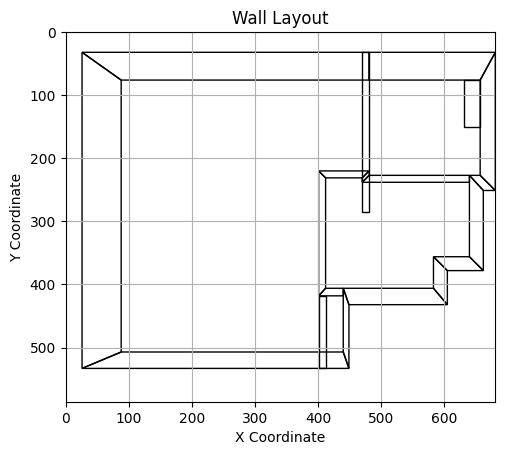

In [44]:
def getWalls(xml, height, width):
    walls = []
    wall_id = 0
    shape = height, width
    for e in xml.getElementsByTagName('g'):
        if e.getAttribute("id") == "Wall":
            wall = PolygonWall(e, wall_id, shape)
            walls.append(wall)
            wall_id += 1

    return walls

for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        svg_path = os.path.join(folder_path, file)
        if not svg_path.endswith('.svg'):
            continue
        xml = minidom.parse(svg_path)
        svg_list = xml.getElementsByTagName('svg')
        for svg in svg_list:
            height = float(svg.getAttribute('height'))
            width = float(svg.getAttribute('width'))
            viewBox = [float(val) for val in svg.getAttribute('viewBox').split(" ")]
            svg_shape = height, width
            walls = getWalls(xml, height, width)
            plot_walls(walls, svg_shape)